# Introduction and Project Purpose
It is through this project I wish to answer a seemingly simple question: 
Does Astrology bear any correlation with life outcomes? Although it's well established that the primordial form of Astrology is [electional](https://en.wikipedia.org/wiki/Electional_astrology), verification of this form of Astrology appears untennable in the absense of a dataset of events that were planned with Astrological significance in mind. Therefore we direct our attention towards [Natal Astrology](https://en.wikipedia.org/wiki/Natal_astrology), the most popular form of Astrology practiced today.

The primary claim of Natal Astrology is that the alignment and movement of planets at a human's date of birth can characterize the way that they interact with the world. From my perspective, it seems that it would then logically follow that factors associated with an individual's personality would also correlate with these Astrological data. 

To answer this question, then, I must find a database of people that includes not only their dates of birth which are fundamental to Astrological computation, but also other variables that we might deep relevant to their personalities.
Once refined and formatted, we can create graphs and run statistical tests to determine if there are any noteworthy correlations that would cause us to reject the implicit null hypothesis that Natal Astrology has no bearing on individual life outcomes. 

To download this entire Jupyter notebook, [click here](https://vera.lgbt/projects/Final/final.ipynb).

# Phase 1: Data Collection & Parsing

Rather than pulling from a known, existing dataset, I've decided to essentially construct my own by querying [Wikidata](https://www.wikidata.org/wiki/Wikidata:Main_Page), the data interface of [Wikipedia](https://www.wikipedia.org/). To obtain this data, I'm using a custom SPARQL query that asks Wikidata for a CSV file, filled with individuals born in New York City, along with their gender, occupation, social media followers, and natural languages known.

### `humans_nyc.csv` query
```
SELECT DISTINCT ?item ?itemLabel ?date_of_birth ?sex_or_genderLabel ?occupation ?social_media_followers ?languages_spoken__written_or_signed WHERE {
  ?item wdt:P31 wd:Q5;
    (wdt:P19/(wdt:P131*)) wd:Q60;
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
  OPTIONAL { ?item wdt:P569 ?date_of_birth. }
  OPTIONAL { ?item wdt:P21 ?sex_or_gender. }
  OPTIONAL { ?item wdt:P106 ?occupation. }
  OPTIONAL { ?item wdt:P8687 ?social_media_followers. }
  OPTIONAL { ?item wdt:P1412 ?languages_spoken__written_or_signed. }
}
ORDER BY DESC (?date_of_birth)
```

Due to the limitations of Wikidata queries and the amount of compute time we are allotted, we cannot actually pull the 'labels' for occupations and labels simultaneously, and instead are fed unique identifiers that are part of the Wikidata system. To remedy this, we have to request those labels as their own queries, which will provide us with the necessary context to infer the true values, rather than the abstract identifiers of these columns.

### `observations.csv` query
```
SELECT DISTINCT ?item ?itemLabel ?itemDescription WHERE {
  ?item wdt:P31 wd:Q12737077;
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
```

### `languages.csv` query
```
SELECT DISTINCT ?item ?itemLabel ?itemDescription WHERE {
  ?item wdt:P31 wd:Q33742;
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
```

Now processed and downloaded, the CSV files in question are available here: { [humans_nyc.csv](https://vera.lgbt/projects/Final/humans_nyc.csv), [languages.csv](https://vera.lgbt/projects/Final/languages.csv), [occupations.csv](https://vera.lgbt/projects/Final/occupations.csv) }

With our data now scraped and ready for processing, let's do some initial setup and get moving!

Here, I'm just importing all the various libraries we'll be utilizing throughout this project.

In [40]:
# Data Manipulation
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
# Astrology
from kerykeion import Report, KrInstance
from datetime import datetime
# Plots
import seaborn as sns
import matplotlib.pyplot as plt
# For displaying images
from PIL import Image
# For statistic tests and interpretation
from sklearn.linear_model import LinearRegression
import statsmodels.api as sma

Now, let's load in the `humans_nyc.csv` database of people into a Pandas DataFrame.

In [41]:
# The file that our people data is stored in
people = pd.read_csv('humans_nyc.csv', encoding='latin-1')
# I don't like a lot of the names of these columns, let's fix that
people.rename({
  'item': 'ID',
  'itemLabel': 'name',
  'languages_spoken__written_or_signed': 'languageID', 
  'social_media_followers': 'followers', 
  'date_of_birth': 'dob',
  'sex_or_genderLabel': 'gender',
  'occupation': 'occupationID'
}, axis=1, inplace=True)
people = people.dropna()
# I also dont like that the ID's are all so long, let's trim them
# They're all share the same prefix 'http://www.wikidata.org/entity/', which is not neccessary
people['ID'] = people['ID'].str[31:]
people['occupationID'] = people['occupationID'].str[31:]
people['languageID'] = people['languageID'].str[31:]
# Lets get a nice look at this data now!
people.head()

,ID,name,dob,gender,occupationID,followers,languageID
35,Q21717770,Isabella Damla GÃ¼venilir,2009-01-18T00:00:00Z,female,Q33999,14570.0,Q256
36,Q21717770,Isabella Damla GÃ¼venilir,2009-01-18T00:00:00Z,female,Q33999,14570.0,Q1860
73,Q62570944,Shahadi Wright Joseph,2005-04-29T00:00:00Z,female,Q33999,10069.0,Q1860
74,Q62570944,Shahadi Wright Joseph,2005-04-29T00:00:00Z,female,Q177220,10069.0,Q1860
75,Q62570944,Shahadi Wright Joseph,2005-04-29T00:00:00Z,female,Q5716684,10069.0,Q1860


In [42]:
occupations = pd.read_csv('occupations.csv', encoding='latin-1')
occupations = occupations.rename(columns={'item': 'occupationID', 'itemLabel': 'occupation', 'itemDescription': 'occupationDescription'})
occupations['occupationID'] = occupations['occupationID'].str[31:]
occupations = occupations.dropna()
occupations.head()

,occupationID,occupation,occupationDescription
2,Q484876,chief executive officer,highest-ranking corporate officer
3,Q619851,gunfighter,a person able to shoot quickly and accurately ...
4,Q694116,miller,person who operates a mill
5,Q488111,pornographic actor,person who performs sex acts in pornographic f...
6,Q484260,guru,"teacher, expert, counsellor, spiritual guide, ..."


In [43]:
languages = pd.read_csv('languages.csv', encoding='latin-1')
languages = languages.rename(columns={'item': 'languageID', 'itemLabel': 'language', 'itemDescription': 'languageDescription'})
languages['languageID'] = languages['languageID'].str[31:]
languages = languages.dropna()
languages.head()

,languageID,language,languageDescription
0,Q36236,Malayalam,Dravidian language of India
1,Q33902,Saraiki,language
2,Q56593,Levantine Arabic,A major variety of Arabic spoken in the Levant
4,Q2669169,Kristang,creole language spoken by the Kristang people
5,Q846157,Shirvani Arabic,dialect of Arabic once spoken in northern Azer...


In [44]:
# Merge people with their occupations
tmp = pd.merge(left=people, right=occupations, how='outer', on=[ 'occupationID' ])
# Merge people with their occupations and their languages
data = pd.merge(left=tmp, right=languages, how='outer', on=[ 'languageID' ])
# Drop ID and Description columns not really relevant to interpretation
data = data.drop(columns=['occupationID', 'occupationDescription', 'languageID', 'languageDescription'])
# Drop invalid entries
data = data.dropna()
# Take a peek!
data.head()

,ID,name,dob,gender,followers,occupation,language
1,Q21717770,Isabella Damla GÃ¼venilir,2009-01-18T00:00:00Z,female,14570.0,actor,English
2,Q62570944,Shahadi Wright Joseph,2005-04-29T00:00:00Z,female,10069.0,actor,English
3,Q26926633,Noah Schnapp,2004-10-03T00:00:00Z,male,845257.0,actor,English
4,Q15148681,Sterling Jerins,2004-06-15T00:00:00Z,female,5930.0,actor,English
5,Q18704998,Mace Coronel,2004-02-19T00:00:00Z,male,54279.0,actor,English


Something is wrong here, though. Though it is hard to notice from just the head, there are actually a great deal of duplicate entries. This seems to occur when the same individual has held multiple occupations over the course of their life. This can be exemplified by asking how many different 'Donald Trump's there are:

In [45]:
data[data["name"] == "Donald Trump"]

,ID,name,dob,gender,followers,occupation,language
569,Q22686,Donald Trump,1946-06-14T00:00:00Z,male,32539172.0,actor,English
570,Q22686,Donald Trump,1946-06-14T00:00:00Z,male,88783411.0,actor,English
2323,Q22686,Donald Trump,1946-06-14T00:00:00Z,male,32539172.0,writer,English
2324,Q22686,Donald Trump,1946-06-14T00:00:00Z,male,88783411.0,writer,English
2665,Q22686,Donald Trump,1946-06-14T00:00:00Z,male,32539172.0,businessperson,English
2666,Q22686,Donald Trump,1946-06-14T00:00:00Z,male,88783411.0,businessperson,English
2740,Q22686,Donald Trump,1946-06-14T00:00:00Z,male,32539172.0,politician,English
2741,Q22686,Donald Trump,1946-06-14T00:00:00Z,male,88783411.0,politician,English
4688,Q22686,Donald Trump,1946-06-14T00:00:00Z,male,32539172.0,investor,English
4689,Q22686,Donald Trump,1946-06-14T00:00:00Z,male,88783411.0,investor,English


Now that this problem has been identified, lets remedy it by eleminating all duplicates on the basis of ID, keeping the last / most recent entry. 

In [46]:
# Drop duplicates that share the same ID
data = data.drop_duplicates(subset='ID', keep="last")
# Take a peek!
data[data["name"] == "Donald Trump"]

,ID,name,dob,gender,followers,occupation,language
5232,Q22686,Donald Trump,1946-06-14T00:00:00Z,male,88783411.0,real estate developer,English


# Phase 2: Data Management & Representation

Now that we have the information that we want, it's time to represent it in a way that is meaningful to us as Astrologers. 

To do this, the first thing that must be done is to transform our date of birth into a workable Python `date` object. Without this representation, we wont be able to easily extract the individual components of the date or generate the Astrological charts associated with each individual.

In [47]:
data['dob'] = data['dob'].str[:10]
data['dob'] = pd.to_datetime(data['dob'], format='%Y-%m-%d', errors = 'coerce')
data.head()

,ID,name,dob,gender,followers,occupation,language
1,Q21717770,Isabella Damla GÃ¼venilir,2009-01-18,female,14570.0,actor,English
3,Q26926633,Noah Schnapp,2004-10-03,male,845257.0,actor,English
4,Q15148681,Sterling Jerins,2004-06-15,female,5930.0,actor,English
5,Q18704998,Mace Coronel,2004-02-19,male,54279.0,actor,English
6,Q44398689,Ashley Gerasimovich,2004-02-01,female,1714.0,actor,English


Now that our date data is usable, let's actually create Astrological chart objects from them.

In [48]:
# Define a custom function that, given a row in our DataFrame, returns a Natal Chart object
def chart(row):
  # Extract date
  date = row['dob']
  # Construct / return object
  return KrInstance(row['name'], int(date.year), int(date.month), int(date.day), 12, 0, "New York City")

# Set the chart column
data['chart'] = data.apply(lambda row: chart(row), axis=1)
# Set the sun column to be the sun sign of the individual, a notable characteristic in Astrology
data['sunSign'] = data.apply(lambda row: row["chart"].sun.sign, axis=1)
# Do the same for the 'element' and 'quality' of the Sun in this natal chart
data['sunElement'] = data.apply(lambda row: row["chart"].sun.element, axis=1)
data['sunQuality'] = data.apply(lambda row: row["chart"].sun.quality, axis=1)
# Take a peek!
data.head()

,ID,name,dob,gender,followers,occupation,language,chart,sunSign,sunElement,sunQuality
1,Q21717770,Isabella Damla GÃ¼venilir,2009-01-18,female,14570.0,actor,English,Astrological data for: Isabella Damla GÃ¼venil...,Cap,Earth,Cardinal
3,Q26926633,Noah Schnapp,2004-10-03,male,845257.0,actor,English,"Astrological data for: Noah Schnapp, 2004-10-0...",Lib,Air,Cardinal
4,Q15148681,Sterling Jerins,2004-06-15,female,5930.0,actor,English,"Astrological data for: Sterling Jerins, 2004-0...",Gem,Air,Mutable
5,Q18704998,Mace Coronel,2004-02-19,male,54279.0,actor,English,"Astrological data for: Mace Coronel, 2004-02-1...",Pis,Water,Mutable
6,Q44398689,Ashley Gerasimovich,2004-02-01,female,1714.0,actor,English,"Astrological data for: Ashley Gerasimovich, 20...",Aqu,Air,Fixed


Now that we've created these Chart objects, it would be prudent to verify their integrity. To do so, I'll print out this libraries stats on a known celebrity, Donald Trump, and compare the stats to those provided by a third party website to ensure congruency. To do this I utilized [astro-charts](https://astro-charts.com), a free website that also stores Astrological data on celbrities. Using this website and the output it provides, we can compare and contrast with Kylerion's output.


+- Kerykeion report for Donald Trump -+
+-----------+------+-------------------+-----------+----------+
| Date      | Time | Location          | Longitude | Latitude |
+-----------+------+-------------------+-----------+----------+
| 14/6/1946 | 12:0 | New York City, US | -74.00597 | 40.71427 |
+-----------+------+-------------------+-----------+----------+
+-----------+------+-------+------+----------------+
| Planet    | Sign | Pos.  | Ret. | House          |
+-----------+------+-------+------+----------------+
| Sun       | Gem  | 22.97 | -    | Tenth House    |
| Moon      | Sag  | 21.74 | -    | Fourth House   |
| Mercury   | Can  | 8.94  | -    | Tenth House    |
| Venus     | Can  | 25.79 | -    | Eleventh House |
| Mars      | Leo  | 26.8  | -    | Twelfth House  |
| Jupiter   | Lib  | 17.45 | R    | Second House   |
| Saturn    | Can  | 23.82 | -    | Eleventh House |
| Uranus    | Gem  | 17.9  | -    | Tenth House    |
| Neptune   | Lib  | 5.84  | R    | First House    |
| P

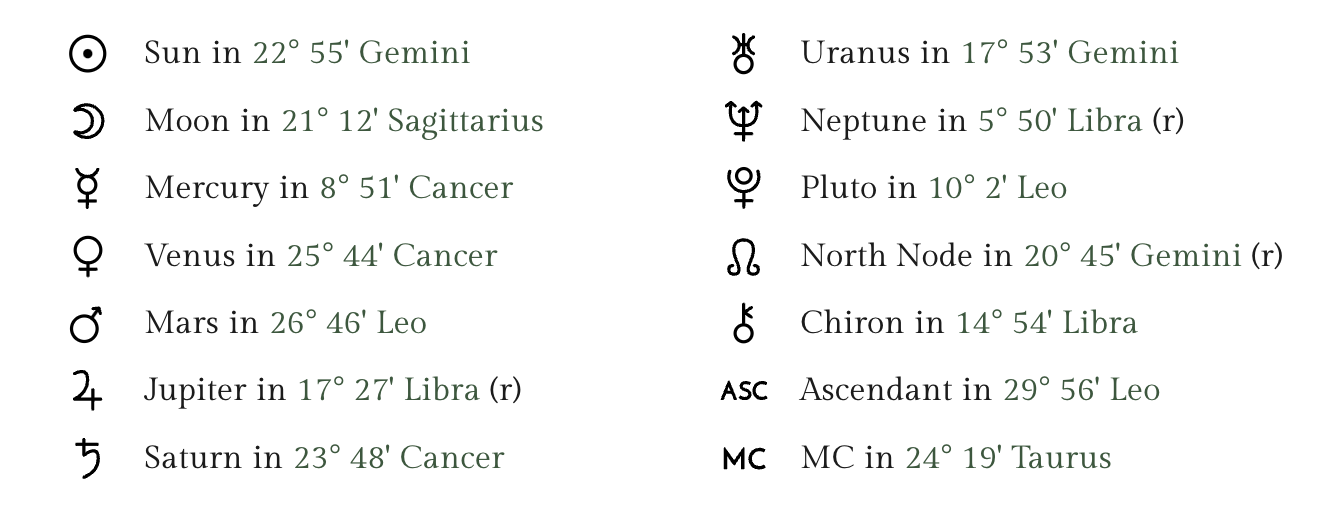

In [49]:
donaldChart = data[data["name"] == "Donald Trump"]["chart"].values[0]
Report(donaldChart).print_report()
Image.open("donald.png")

While there are significant discrepancies between the actual known data and the data we've constructed here, they're most likely due to an inaccuracy in time reporting on our part. Noting that each of the planets are still in the correct Sign, we can say that for our purposes, this is close enough.

# Phase 3: Exploratory data analysis

Now the fun part, let's see what's in our data!
Let's start by taking a peek at the distribution of Sun signs, since we want to do interpretation relating to them.

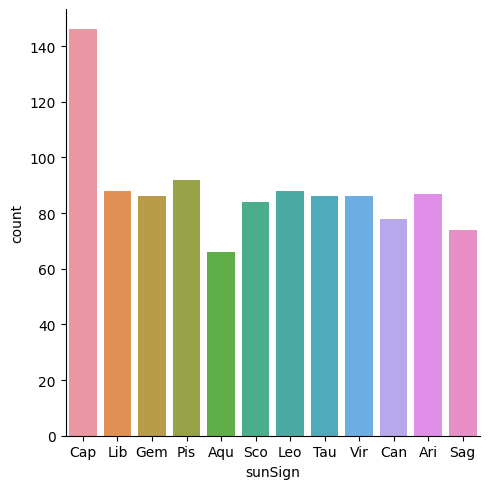

In [50]:
sns.catplot(data=data, x="sunSign", kind="count")

...That's a bit odd. Why are there so many Capricorns? Could it be that notable people are simply more likely to be Capricorns, and this is why they are overrepresented in the dataset?
I have a sneaking suspicion that this isn't the case, so let's investigate a little bit further. 

To be born with your Sun Sign in Capricorn, you need to be born roughly between December 22 and January 19. My suspicion here is that for legacy reasons, the January 1st date has been defaulted to as a birthday and is therefore overrepresented in our dataset! Let's investigate.

In [51]:
print(len(data[(data["dob"].dt.month == 1) & (data["dob"].dt.day == 1)]))
print(len(data[(data["dob"].dt.month == 1) & (data["dob"].dt.day == 2)]))
print(len(data[(data["dob"].dt.month == 1) & (data["dob"].dt.day == 3)]))

59
3
2


As we can see, there are nearly 60 individuals born on January 1st, while there are only 3 and 2 respectively for January 1st and 2nd. Let's fix this by cutting out anyone born on January 1st to get a more normal distribution of sun signs.

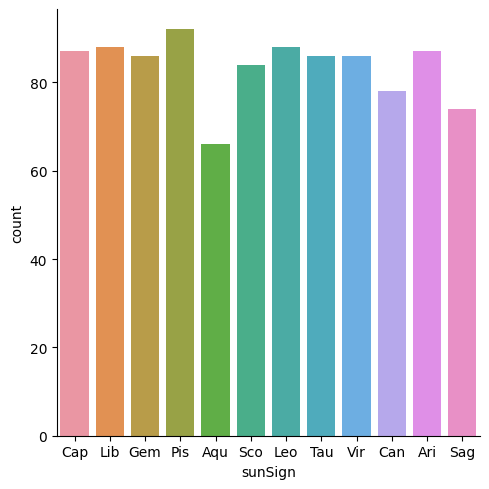

In [52]:
data = data[data["dob"].dt.month + data["dob"].dt.day != 2]
sns.catplot(data=data, x="sunSign", kind="count")

Yay! Look at that! Now we have a much more even distribution, and can even see that there are slightly less Aquariuses, which makes sense considering they are known to be less prevalent. Now we can more safely engage in data analysis and hypothesis testing with the knowledge that our data has been normalized to a degree.

# Phase 4: Hypothesis testing

To start, let's see if the Element of the Sun Sign has any bearing on internet popularity. Our hypothesis here is that if Astrological readings have bearings on personality, they will also have a bearing on internet popularity.

<AxesSubplot: xlabel='followers', ylabel='sunElement'>

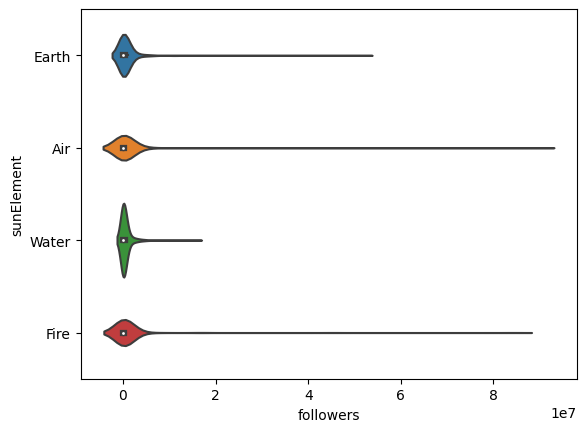

In [53]:
sns.violinplot(data=data, x="followers", y="sunElement")

Hm.. this isn't very legible. It seems that to make any use of the `followers` variable, we'll have to examine its logarithm instead. Let's make a new column to do just that.

<AxesSubplot: xlabel='logFollowers', ylabel='sunElement'>

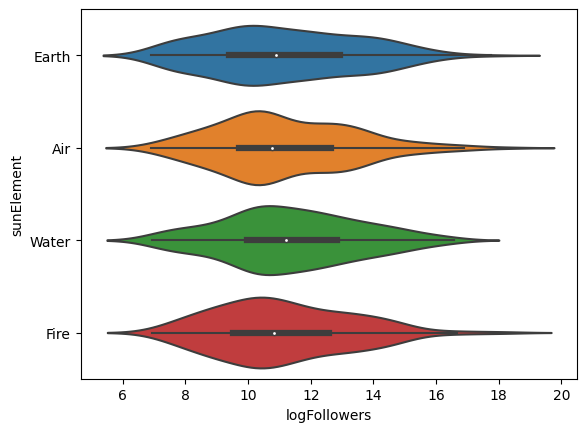

In [54]:
data["logFollowers"] = data.apply(lambda row: np.log(row['followers']), axis=1)
sns.violinplot(data=data, x="logFollowers", y="sunElement")

<AxesSubplot: xlabel='logFollowers', ylabel='sunQuality'>

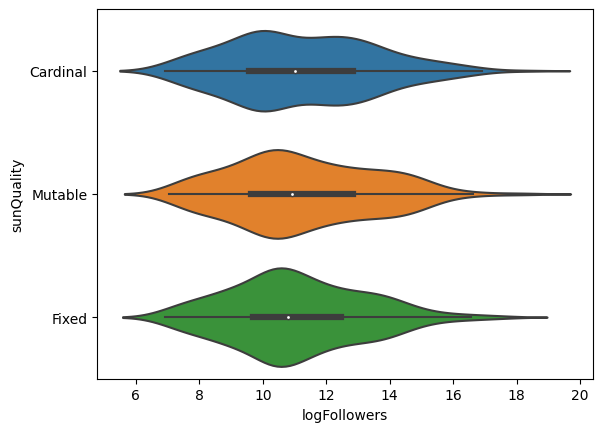

In [55]:
sns.violinplot(data=data, x="logFollowers", y="sunQuality")

<AxesSubplot: xlabel='logFollowers', ylabel='sunSign'>

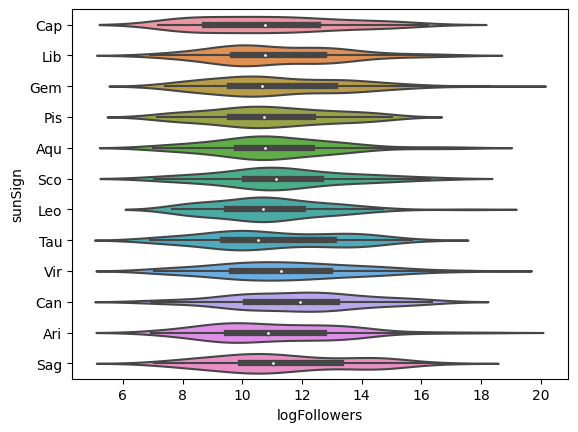

In [56]:
sns.violinplot(data=data, x="logFollowers", y="sunSign")

As expected, the individual's Sun Sign doesn't seem to have much impact on their popularity. Even in the absence of a proper statistical test, it appears we still have no reason to reject our null hypothesis.

To ensure this isn't just a fluke, let's contrast this with two variables that we would actually expect to correlate more meaningfully. 

Let's try occupation against follower count, as we would expect that there are meaningful connections there. First, we need to eliminate the occupations that are too rare to be statistically relevant. Let's do that now.

In [57]:
# Construct counts of each occupation type
occupationCounts = data["occupation"].value_counts()
# Save these in a column
data["occupationValueCount"] = data.apply(lambda row: occupationCounts[row['occupation']], axis=1)
# Create a new DataFrame that only stores rows for prevalent occupations
poData = data[data["occupationValueCount"] > 30]

<AxesSubplot: xlabel='logFollowers', ylabel='occupation'>

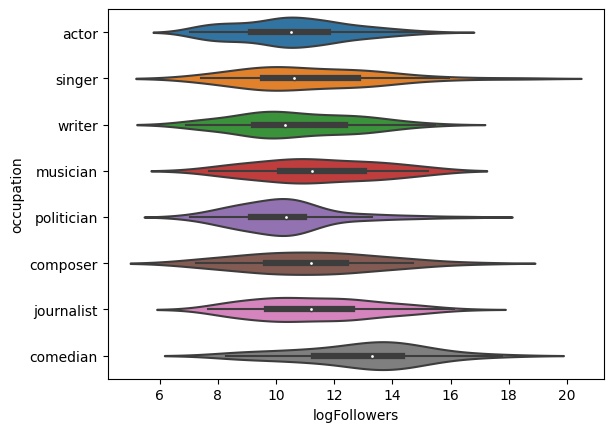

In [58]:
sns.violinplot(data=poData, x='logFollowers', y='occupation')

Here, we can see that occupation actually has a strong or at least a significant bearing on followers, as expected. In particular, it seems that comedians and musicians are followed at higher rates than other professions, which makes sense on an intuitive level given that they might say something funny or post new music!

While not entirely relevant to the question we are trying to answer, this does confirm that there are correlations to be found in this data, it just so happens that our categorical Astrological data does not seem to bear correlation as of yet.

With this in mind, let's try to test another hypothesis. Rather than trying to associate followers with Astrological data, let's now do this for occupations! In this way, we're trying to find associations between an individuals Natal Sun and the occupation they inhabit. Because we're now working with two categorical variables, we'll be looking at a much different set of graphs, but we're still expecting to see that the values we see are similar across occupations.

[]

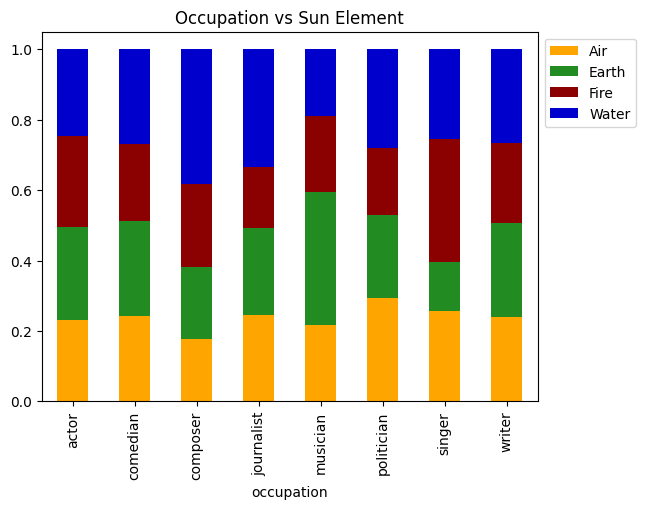

In [59]:
elementPalette = ['orange', 'forestgreen', 'darkred', 'mediumblue']
graph = pd.crosstab(poData['occupation'], poData['sunElement'], normalize='index').plot.bar(stacked=True, color=elementPalette)
graph.legend(bbox_to_anchor=(1.0, 1.0))
graph.set_title("Occupation vs Sun Element", color='black')
graph.plot()

[]

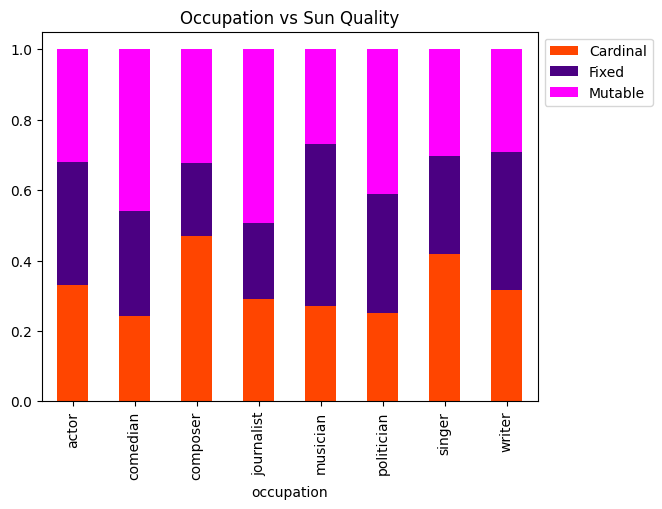

In [60]:
qualityPalette = ['orangered', 'indigo', 'magenta']
graph = pd.crosstab(poData['occupation'], poData['sunQuality'], normalize='index').plot.bar(stacked=True, color=qualityPalette)
graph.legend(bbox_to_anchor=(1.0, 1.0))
graph.set_title("Occupation vs Sun Quality", color='black')
graph.plot()

[]

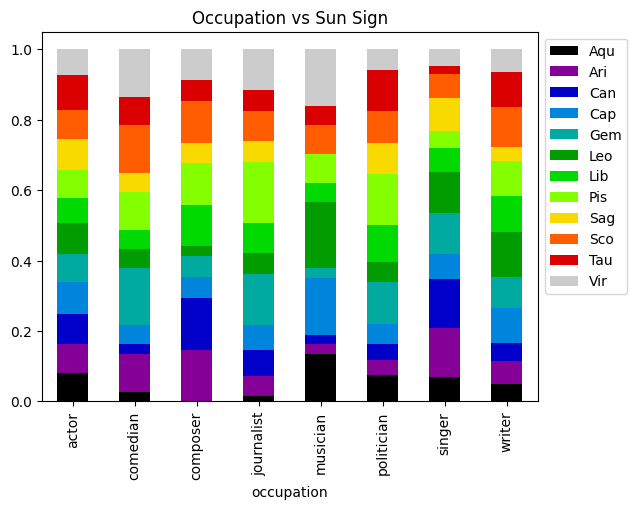

In [61]:
graph = pd.crosstab(poData['occupation'], poData['sunSign'], normalize='index').plot.bar(stacked=True, cmap=plt.get_cmap('nipy_spectral'))
graph.legend(bbox_to_anchor=(1.0, 1.0))
graph.set_title("Occupation vs Sun Sign", color='black')
graph.plot()

Well this is a bit surprising! It seems that these variables actually have a correlation with Astrological sign. Let's do the same thing we did in our previous exploration by comparin this to a variable we *wouldn't* expect to have a correlation with sun Sign, in this case `gender`.

[]

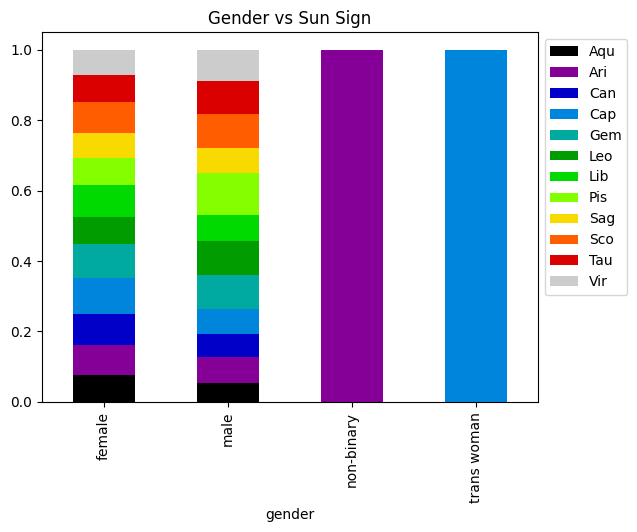

In [62]:
graph = pd.crosstab(poData['gender'], poData['sunSign'], normalize='index').plot.bar(stacked=True, cmap=plt.get_cmap('nipy_spectral'))
graph.legend(bbox_to_anchor=(1.0, 1.0))
graph.set_title("Gender vs Sun Sign", color='black')
graph.plot()

Interesting! This reveals that, while there is a degree of fluctuation in our filtered dataset, this likely doesn't account for the variation we see in our data. At the same time, though, it does appear that the occupations with the higher number of occurrences are the ones with higher occurrence counts. This could, after all, just be a case of not enough data! Let's wrap up by performing some actual statistical tests that will give us some insight into whether there are statistically significant correlations here. 

First, let's define a function that, given a model and the X and y variables we trained it on, scores that data's R2 and determines the P-values for each of the relevant variables.

In [63]:
def m_summary(model, X, y):
  print(f"y = {model.coef_[0][-1]}x + {model.intercept_[0]}")
  print(f"score: {model.score(X, y)}")
  est = sma.OLS(y, sma.add_constant(X))
  fit = est.fit()
  print(fit.pvalues)

Now, let's set up and train a few models. First, I want to return to gender as a metric for followers. We should expect to see a very low score and very high P-values.

In [64]:
# Hot encode the categorical data
data = pd.concat([data, pd.get_dummies(data['gender'])], axis=1)
# Set X to be the dummy columns
X = data[['male', 'female']]
# Set Y to be the life expectancy
y = pd.DataFrame(data['followers'])
model = LinearRegression()
model.fit(X, y)
# Output
m_summary(model, X, y)

y = 443150.1631762606x + 567111.6666666707
score: 0.00019830690397359962
const     0.776385
male      0.875777
female    0.825695
dtype: float64


Our suspicions are confirmed, gender has virtually no correlation and this model fails to account for almost any variances whatsoever.

Let's now do the same but for occupation, expecting to find a slight correlation and by extension a higher score and lower P-values.

In [65]:
# Hot encode the categorical data
poData = pd.concat([poData, pd.get_dummies(poData['occupation'])], axis=1)
# Set X to be the dummy columns
X = poData[['actor', 'comedian', 'composer', 'journalist', 'musician', 'politician', 'singer', 'writer']]
# Set Y to be the life expectancy
y = pd.DataFrame(poData['followers'])
model = LinearRegression()
model.fit(X, y)
# Output
m_summary(model, X, y)

y = 2.2216917906547256e+18x + -2.2216917906544404e+18
score: 0.035537893481734306
const         5.523237e-07
actor         1.806345e-02
comedian      1.706162e-03
composer      9.045231e-01
journalist    4.442004e-01
musician      5.531202e-01
politician    2.779397e-01
singer        7.473999e-03
writer        1.668012e-01
dtype: float64


Lovely! Our comedians are actually predictive with a 0.001706 P-value, which indicates a strong correlation found! Simultaneously our R2 is up to 0.03, which, although we still fail to explain most of the data variance, indicates that these variables are *less independent* than the previous two we examined.

Finally, let's run a test for our Astrological data, comparing the quality of an individual's Sun to their follower count.

In [66]:
# Hot encode the categorical data
data = pd.concat([data, pd.get_dummies(data['sunQuality'])], axis=1)
# Set X to be the dummy columns
X = data[['Cardinal', 'Fixed', 'Mutable']]
# Set Y to be the life expectancy
y = pd.DataFrame(data['followers'])
model = LinearRegression()
model.fit(X, y)
# Output
m_summary(model, X, y)

y = 3.964568942166597e+19x + -3.964568942166496e+19
score: 0.0007185893322776415
const       2.906234e-09
Cardinal    1.439460e-01
Fixed       8.716319e-01
Mutable     1.289788e-01
dtype: float64


In [67]:
# Hot encode the categorical data
data = pd.concat([data, pd.get_dummies(data['sunSign'])], axis=1)
# # Set X to be the dummy columns
X = data[['Aqu', 'Ari', 'Can', 'Cap', 'Gem', 'Leo', 'Lib', 'Pis', 'Sag', 'Sco', 'Tau', 'Vir']]
# Set Y to be the life expectancy
y = pd.DataFrame(data['followers'])
model = LinearRegression()
model.fit(X, y)
# Output
m_summary(model, X, y)

y = 2.2599079310566806e+19x + -2.2599079310565396e+19
score: 0.006193635056726987
const    2.770617e-09
Aqu      8.699674e-01
Ari      2.016947e-01
Can      7.509675e-01
Cap      6.489259e-01
Gem      1.508482e-01
Leo      7.772818e-01
Lib      9.289996e-01
Pis      2.803997e-01
Sag      9.520820e-01
Sco      9.378182e-01
Tau      4.566120e-01
Vir      2.927813e-01
dtype: float64


Here, we again see almost no correlation whatsoever, neither for the Quality of the Sun nor its Sign. None of these P-values are below our desired 0.05 threshold, and similarly the R2 score fails to explain almost any data at all.

# Phase 5: Communication of Insights Attained

First and foremost, I acknowledge that we fail to reject our null hypothesis. We still, for all our efforts, have no reason to believe that Natal Astrology has a bearing on life outcomes.  

While our findings here may not be the most surprising in the field of data analytics and even less surprising among [Rationalists](https://en.wikipedia.org/wiki/Rationalism) such as [Max](https://www.cs.umd.edu/people/morawski), there is from my perspective a disheartening lack of interest in the statistical investigation of matters such as this one. Fields that have been relegated to the realm of pseudoscience are ripe for scientific analysis, but it seems there is a diminishing interest in actually studying them. 

While it could be argued that scientists lack interest in these fields because they expect to find no meaningful correlation, being unable to find correlation is in itself a meaningful result. It also provides insight into cultural practices that may be obscured to the scientific community. For example, I'm sure that if this article is to reach any Astrologers more well versed than myself, they will enumerate a long list of reasons why a test such as this one is incongruent with the teachings of classical Astrology. By asking questions such as these, we don't just learn about the correlations that may or may not be there, we also learn what practitioners of these traditions consider relevant and worthwhile. 

Therefore even if it appears that this article is not 'insightful', I maintain that it is! We cannot simply dismiss traditions on the basis that they were not born of scientific movements, instead we must thoroughly investigate them with the tools of science. If we do not, our belief that they are unfounded is equally unfounded as their belief is to begin with.

As much as I hoped to find something surprising in this data, I hope that this article captures my motivation for this project, the conclusions that I've drawn, and the value I believe this provides.